In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import rotate

We can open the list mode data as follows:

In [2]:
def open_listmode(filepath):
    d = np.fromfile(filepath, dtype=[('x0', np.int16), ('y0', np.int16), ('z0', np.int16), ('xp', np.int16), ('yp', np.int16), ('zp', np.int16), ('x', np.int16), ('y', np.int16), ('z', np.int16), ('E', np.int16), ('w', np.float64), ('s', np.int8)])
    return d

In [3]:
data = open_listmode('test.lmf')

In [6]:
data['E']/10

array([135.8, 105.2,  87.3, ..., 123.3, 125.4,  85.7])

Each entry in data gives the statistics for a single simulated photon
* The weight `w` allows us to determine the contribution in CPS/MBq

# Energy Spectrum

Lets bin by different energies

In [7]:
bins = np.linspace(0,300,300)
energies = data['E'].astype(float)/10
weights = np.abs(data['w'])
N, bin_edges = np.histogram(energies, bins=bins, weights=weights)
bins = bin_edges[:-1] + np.diff(bin_edges) / 2

Now we can plot the energy spectrum

Text(0, 0.5, 'Proportion [arb]')

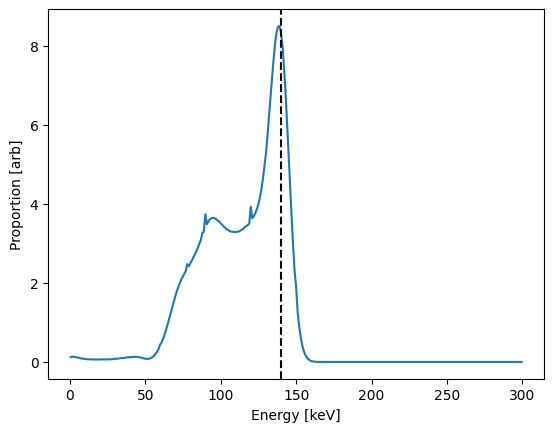

In [8]:
plt.plot(bins, N)
plt.axvline(140, ls='--', color='k')
plt.xlabel('Energy [keV]')
plt.ylabel('Proportion [arb]')

We simulated only photon of 140keV though. Why is the spectrum so spread out?

### 1. Scatter (in the phantom)
Photons scatter in the phantom and lose energy, and subsequently become detected at smaller energies. We can choose to look only at primary photons by indexing only when `data['s']==0`. We can look at scattered events only by setting `data['s']>=1`. Lets write a function for this:

In [9]:
def get_energy_histogram(filepath, include='all'):
    d = open_listmode(filepath)
    bins = np.linspace(0,300,300)
    if include=='all':
        weights=np.abs(d['w'])
    elif include=='primary':
        weights=np.abs(d['w'])*(d['s']<1)
    elif include=='scatter':
        weights=np.abs(d['w'])*(d['s']>=1)
    N, bin_edges = np.histogram(d['E'].astype(float)/10, bins=bins, weights=weights)
    bins = bin_edges[:-1] + np.diff(bin_edges) / 2
    return bins, N

In [10]:
hist_all = get_energy_histogram('test.lmf', include='all')
hist_primary = get_energy_histogram('test.lmf', include='primary')
hist_scatter = get_energy_histogram('test.lmf', include='scatter')

Text(0, 0.5, 'Proportion [arb]')

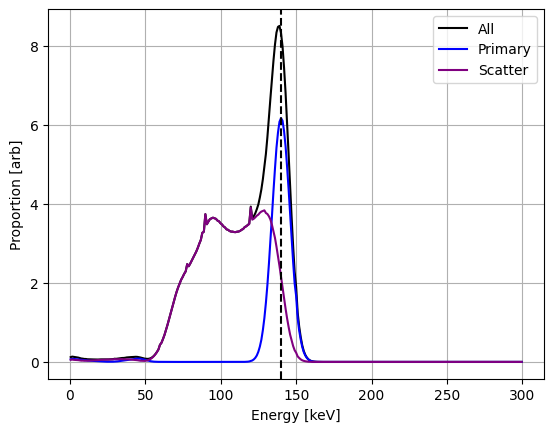

In [11]:
plt.plot(*hist_all, color='k', label='All')
plt.plot(*hist_primary, color='b', label='Primary')
plt.plot(*hist_scatter, color='purple', label='Scatter')
plt.legend()
plt.grid()
plt.axvline(140, ls='--', color='k')
plt.xlabel('Energy [keV]')
plt.ylabel('Proportion [arb]')

### 2. Energy Resolution

Lets open up the data with better energy resolution:

In [12]:
hist2_all = get_energy_histogram('test2.lmf', include='all')
hist2_primary = get_energy_histogram('test2.lmf', include='primary')
hist2_scatter = get_energy_histogram('test2.lmf', include='scatter')

Lets plot the 2 primary spectra together

Text(0, 0.5, 'Proportion [arb]')

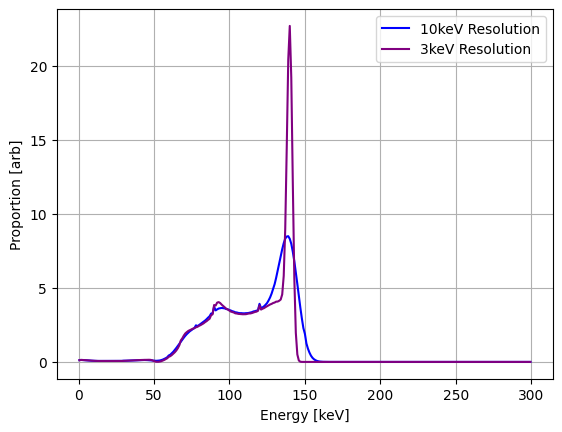

In [14]:
plt.plot(*hist_primary, color='b', label='10keV Resolution')
plt.plot(*hist2_primary, color='purple', label='3keV Resolution')
plt.legend()
plt.grid()
plt.xlabel('Energy [keV]')
plt.ylabel('Proportion [arb]')

As can be seen, the simulation with 3keV resolution gives values much closer to the true photopeak value.

### 3. Back Scatter Peak
There's still that pesk bump at around 50keV though. This still corresponds to 140keV photons that weren't scattered in the phantom, but rather than depositing *all* their energy in the crystal, they compton scatter and deposit only a fraction of their energy. The new energy of the photon after compton scattering

$$E' = \frac{E}{1+(E/mc^2)(1-\cos\theta)}$$

where $m$ is the mass of the electron. The energy deposition in the crystal is then $E_{\text{deposited}} = E-E'$. The greatest possible deposition is when $E'$ is minimized, or when $\theta=\pi$ and

$$E_{\text{deposited,max}} = \left(\frac{2E}{2E+mc^2}\right) E$$

In [18]:
E = 140
mc2 = 511
E_deposited_max = (2*E/(2*E+mc2))*E 
print('Backscatter peak = ', round(E_deposited_max,2), ' keV')

Backscatter peak =  49.56  keV


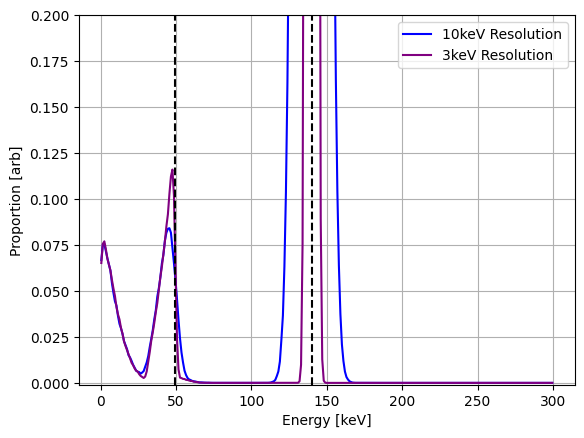

In [22]:
plt.plot(*hist_primary, color='b', label='10keV Resolution')
plt.plot(*hist2_primary, color='purple', label='3keV Resolution')
plt.legend()
plt.grid()
plt.xlabel('Energy [keV]')
plt.ylabel('Proportion [arb]')
plt.ylim(-0.001, 0.2)
plt.axvline(E_deposited_max, color='k', ls='--')
plt.axvline(140, color = 'k', ls = '--')

# Spatial Binning

In the 'scattwin' routine, listmode data is automatically binned based on
* Index 28 (pixel size)
* Index 76/77 (matrix size)
* A `.win` file that gives energy windows to only include events with certain energies

We can also bin the listmode data directly ourselves, to gain further understanding of what's going on. Firstly, note that the listmode data stores **all** projections; we only want to consider one projection at a time
* The start of a new projection is signified by `data['s'] = -1`

In [25]:
data = open_listmode('test.lmf')
split_indices = np.where(data['w']<0)[0]
split_indices

array([18075435, 36150921], dtype=int64)

Lets modify this array slightly

In [26]:
split_indices = np.insert(split_indices, 0, 0)
split_indices = np.append(split_indices, -1)
split_indices

array([       0, 18075435, 36150921,       -1], dtype=int64)

Now to index projection `i` we take the events from indices `split_indices[i]` to `split_indices[i+1]`

In [27]:
ds = [data[split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]
len(ds)

3

Let's encode this in a single function

In [28]:
def open_listmode_projections(filepath):
    d = open_listmode(filepath)
    split_indices = np.where(d['w']<0)[0]
    split_indices = np.insert(split_indices, 0, 0)
    split_indices = np.append(split_indices, -1)
    d['w'] = np.abs(d['w'])
    ds = [d[split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]
    return ds

In [29]:
data_seperated = open_listmode_projections('test.lmf')

Now we can bin each of the projections. Let's consider the first projection

In [30]:
data0 = data_seperated[0]

In [32]:
Nx = 128
Ny = 128
dx = 0.1
dy = 0.1
binsx = np.arange(-Nx/2*dx, (Nx/2+1)*dx, dx)
binsy = np.arange(-Ny/2*dy, (Ny/2+1)*dy, dy)

Now we can make a mask for only the energies we want

In [35]:
Emin = 126
Emax = 154
energy_mask = (data0['E'].astype(float)/10 > Emin) * (data0['E']/10 < Emax)

Finally we can bin:

In [36]:
x_detected = data0['x'][energy_mask].astype(float)/100
y_detected = data0['y'][energy_mask].astype(float)/100
weights = np.abs(data0['w'])[energy_mask]
counts, x, y = np.histogram2d(x_detected, y_detected, bins=(binsx,binsy), weights=weights)

Now our "counts" is actually a 2D array

In [37]:
counts.shape

(128, 128)

Which we can plot

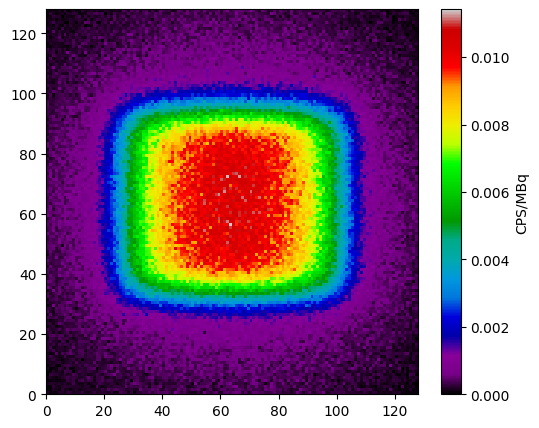

In [38]:
plt.figure(figsize=(6,5))
plt.pcolormesh(counts.T, cmap='nipy_spectral')
plt.colorbar(label='CPS/MBq')
plt.show()

Lets put this into a function, and make it so its automatically applied to all projections

In [39]:
def bin_projections(filepath, Emin, Emax, dx, dy, Nx, Ny):
    binsx = np.arange(-Nx/2*dx, (Nx/2+1)*dx, dx)
    binsy = np.arange(-Ny/2*dy, (Ny/2+1)*dy, dy)
    data_seperated = open_listmode_projections(filepath)
    projections = []
    for data in data_seperated:
        energy_mask = (data['E'].astype(float)/10 > Emin) * (data['E']/10 < Emax)
        x_detected = data['x'][energy_mask].astype(float)/100
        y_detected = data['y'][energy_mask].astype(float)/100 
        weights = np.abs(data['w'])[energy_mask] 
        counts, x, y = np.histogram2d(x_detected, y_detected, bins=(binsx,binsy), weights=weights)
        projections.append(counts)
    return np.array(projections)

Now we can bin our projections however we like:

In [40]:
projections_highres = bin_projections('test.lmf', 126, 140, 0.1, 0.1, 128, 128)
projections_lowres = bin_projections('test.lmf', 126, 140, 0.4, 0.4, 32, 32)

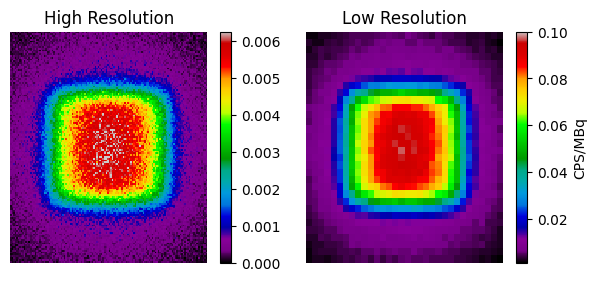

In [41]:
idx = 0
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.pcolormesh(projections_highres[idx].T, cmap='nipy_spectral', vmax=0.1/16)
plt.colorbar()
plt.axis('off')
plt.title('High Resolution')
plt.subplot(122)
plt.pcolormesh(projections_lowres[idx].T, cmap='nipy_spectral', vmax=0.1)
plt.colorbar(label='CPS/MBq')
plt.axis('off')
plt.title('Low Resolution')
plt.show()

Note that the high resolution scan looks noisey, even though it should be smooth. This noise is **not** Poisson noise inherit in the scan. It is noise induced from not simulating enough Monte Carlo events to get good statistics at this resolution. The Poisson noise is determined once an activity and time has been set

In [42]:
activity = 50 # MBq
time = 15
projections_highres_noise = np.random.poisson(projections_highres*activity*time)
projections_lowres_noise = np.random.poisson(projections_lowres*activity*time)

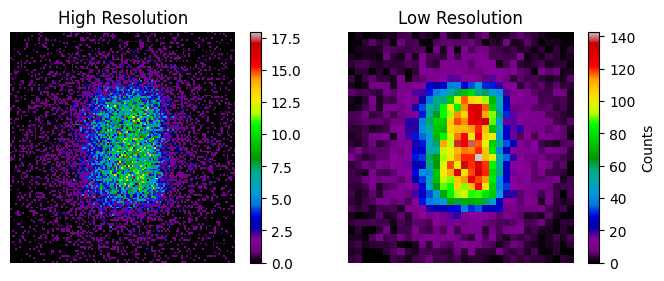

In [43]:
idx = 1
plt.subplots(1,2,figsize=(8,3))
plt.subplot(121)
plt.pcolormesh(projections_highres_noise[idx].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('High Resolution')
plt.subplot(122)
plt.pcolormesh(projections_lowres_noise[idx].T, cmap='nipy_spectral')
plt.colorbar(label='Counts')
plt.axis('off')
plt.title('Low Resolution')
plt.show()

Notice that the high resolution data is noisier, which is too be expected (trade off for noise vs resoltuion)

# Emission Points

We can also get access to individual emission 3D points from listmode data

* Obviously this is not possible in real life, as we only read data from a scanner. The purpose of *reconstruction algorithms* is to attempt to obtain this information as best as possible

In [44]:
def bin_source(filepath, dx, N):
    bins= np.arange(-N/2*dx, (N/2+1)*dx, dx)
    data = open_listmode(filepath)
    x_emitted = data['x0'].astype(float)/100
    y_emitted = data['y0'].astype(float)/100 
    z_emitted = data['z0'].astype(float)/100 
    weights = np.abs(data['w'])
    emissions, b = np.histogramdd((x_emitted, y_emitted, z_emitted), bins=3*[bins], weights=weights)
    return emissions

In [45]:
source = bin_source('test.lmf', 0.1, 128)

Let's look at the central z-slice

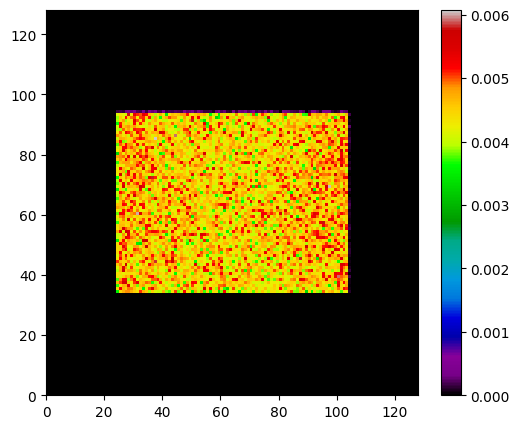

In [46]:
plt.figure(figsize=(6,5))
plt.pcolormesh(source[:,:,64], cmap='nipy_spectral')
plt.colorbar()

In pratice, if you know the configuration of the source geometry, you don't need to do this. In our case, we know that it's a cylinder with specified dimensions, so we could just make the mask on our own

We can make a 3D animation of the source

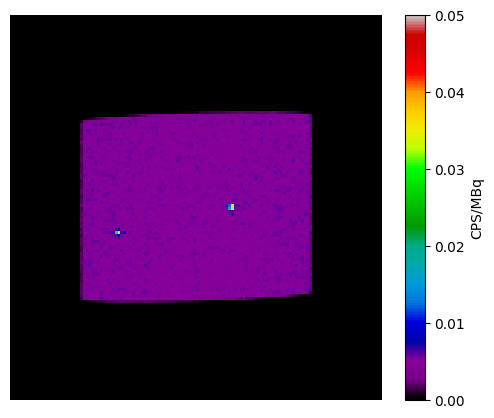

In [47]:
fig, ax = plt.subplots(figsize=(6,5))

def update_plot(frame):
    plt.clf()
    im = rotate(source, 5*frame, axes=(2,1), reshape=False)
    im = rotate(im, 10, axes=(0,2), reshape=False).max(axis=2) # rotate camera angle up a little
    C = plt.pcolormesh(im, cmap='nipy_spectral', vmin=0, vmax=0.05)
    plt.axis('off')
    plt.colorbar(label='CPS/MBq')
    return C, 

anim = FuncAnimation(fig, update_plot, interval=30, blit=True, frames=71)
anim.save(f'source.gif', writer='pillow', fps=30, dpi=200)